In [1]:
# Run this cell to configure Tensorflow to use your GPU
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

E0000 00:00:1762715949.134586   72796 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762715949.140308   72796 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
import keras_cv
model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", bounding_box_format="xywh"
)

I0000 00:00:1762715954.232791   72796 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


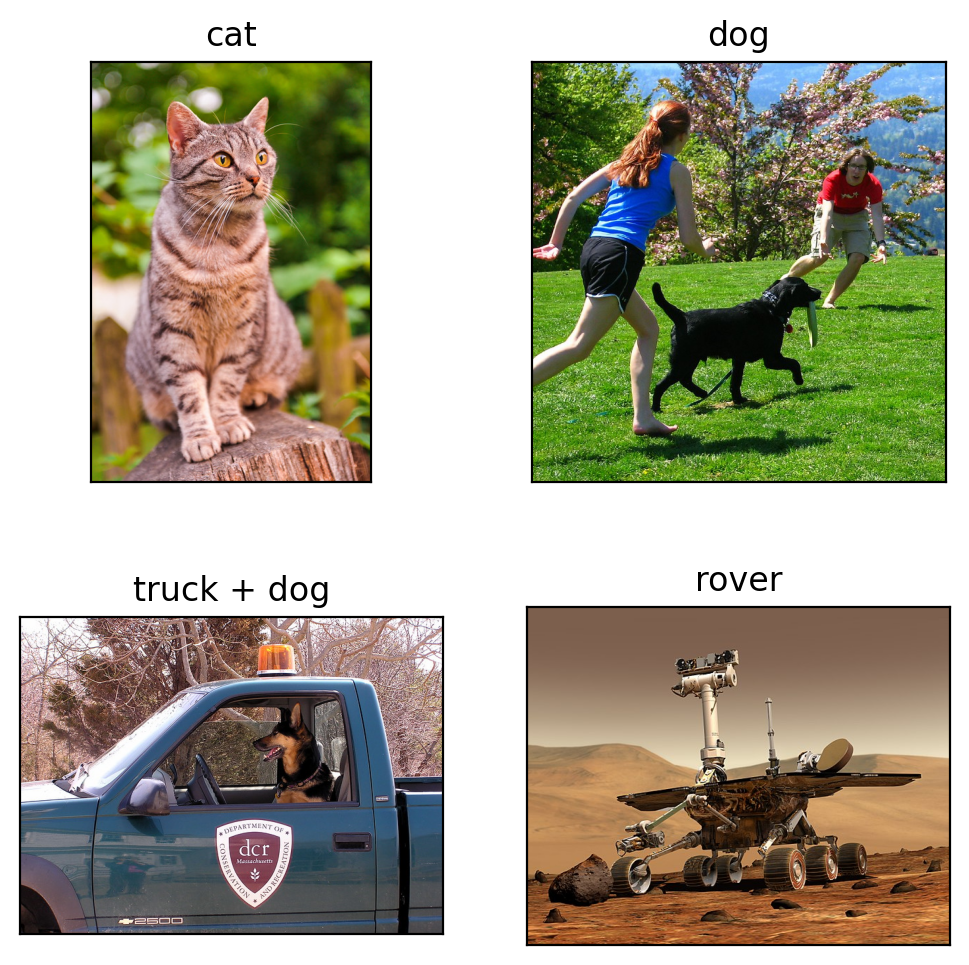

In [3]:
from collegium.m02_cnn.utils.plot import *

# Loads a tiny batch of images from Internet
images_raw = load_tiny_batch()
plot_images_grid(images_raw)

In [4]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)
model_inputs = {
    k: inference_resizing(i)
    for k, i in images_raw.items()
}

In [5]:
# Running a forward pass through the network with the input image.
model_outputs = {
    k: model.predict(i[None, :])
    for k, i in model_inputs.items()
}

I0000 00:00:1762715962.136261   72903 service.cc:148] XLA service 0x7c7fe0002800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762715962.136285   72903 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762715962.957190   72903 cuda_dnn.cc:529] Loaded cuDNN version 91301
E0000 00:00:1762715965.296887   72903 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762715965.499516   72903 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


I0000 00:00:1762715970.254200   72903 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


In [6]:
# The result is a dictionary of tensors, so let's look at the shapes.
{name: r.shape for name, r in model_outputs['cat'].items()}

{'boxes': (1, 100, 4),
 'confidence': (1, 100),
 'classes': (1, 100),
 'num_detections': (1,)}

In [7]:
# Non-Max Supression
# This algorithm groups boxes that have large overlap,
# and selects at most one box from each overlapping group.
# This prevents incorrect multiple detection of the same object.
# See: https://www.tensorflow.org/api_docs/python/tf/image/non_max_suppression

for name in model_outputs:
    max_objects = model_outputs[name]['num_detections'][0]
    boxes = model_outputs[name]['boxes'][0].copy()
    boxes[:, [2, 3]] += boxes[:, [0, 1]]

    selected_idxs = tf.image.non_max_suppression(
        boxes, 
        model_outputs[name]['confidence'][0], 
        score_threshold=0.5,
        max_output_size=100,
        iou_threshold=0.8,
    ).numpy()

    # assign -1 confidence to boxes that were not selected
    full_mask = np.repeat(False, boxes.shape[0])
    full_mask[selected_idxs] = True
    full_mask = full_mask.astype(bool)
    model_outputs[name]['confidence'][0][~full_mask] = -1

In [8]:
# We need to load a mapping between integer class IDs and English labels.
# There is a helper function in utils folder to do just that.

from collegium.m02_cnn.utils.pascalvoc import load_class_map
class_map = load_class_map()
class_map

label
0      Aeroplane
1        Bicycle
2           Bird
3           Boat
4         Bottle
5            Bus
6            Car
7            Cat
8          Chair
9            Cow
10  Dining Table
11           Dog
12         Horse
13     Motorbike
14        Person
15  Potted Plant
16         Sheep
17          Sofa
18         Train
19     Tvmonitor
20         Total

In [9]:
# Now we can use the data frame from above to convert
# the model output (integer IDs) to the corresponding English labels.
import pandas as pd

def model_output_to_scores_df(model_output: dict) -> pd.DataFrame:
    class_ids = np.clip(model_output['classes'][0].astype(int), 1, None)
    class_labels = class_map.loc[class_ids].reset_index(drop=True)
    class_scores = pd.Series(model_output['confidence'][0]).rename('score')

    class_predictions = pd.concat([class_labels, class_scores], axis=1)
    class_predictions = class_predictions.sort_values('score', ascending=False)
    class_predictions = class_predictions.loc[class_predictions['score'] > 0.5]
    
    return class_predictions

def plot_image_with_boxes(input_image: np.ndarray, model_output: dict):
    class_ids = np.clip(model_output['classes'][0].astype(int), 1, None)
    class_labels = class_map.loc[class_ids].reset_index(drop=True)
    
    image_with_boxes = draw_boxes(
        np.array(input_image), 
        model_output["boxes"][0],
        class_labels.label.values,
        model_output["confidence"][0],
        min_score=0.50,
    )
    plt.figure(figsize=[4, 4])
    plot_image(image_with_boxes)

label     score
0   Cat  0.982062

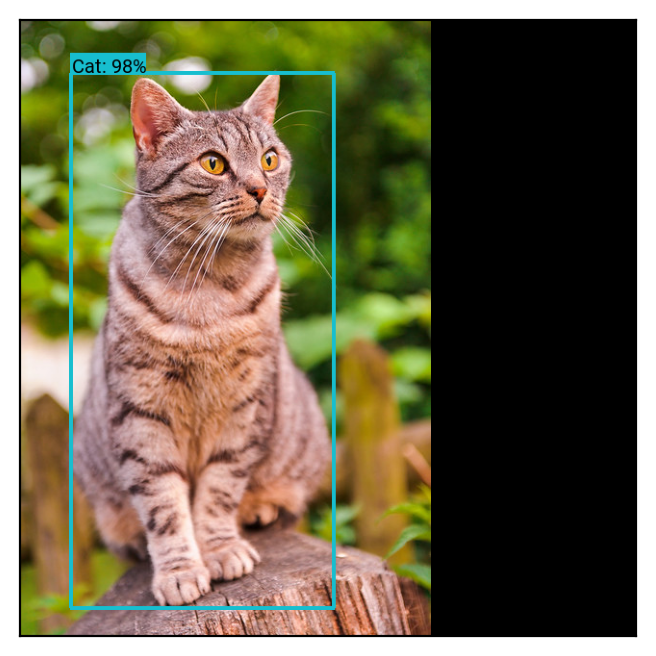

In [10]:
plot_image_with_boxes(model_inputs['cat'], model_outputs['cat'])
model_output_to_scores_df(model_outputs['cat']).head(5)

label     score
0   Person  0.975369
3   Person  0.944859
15     Dog  0.893673

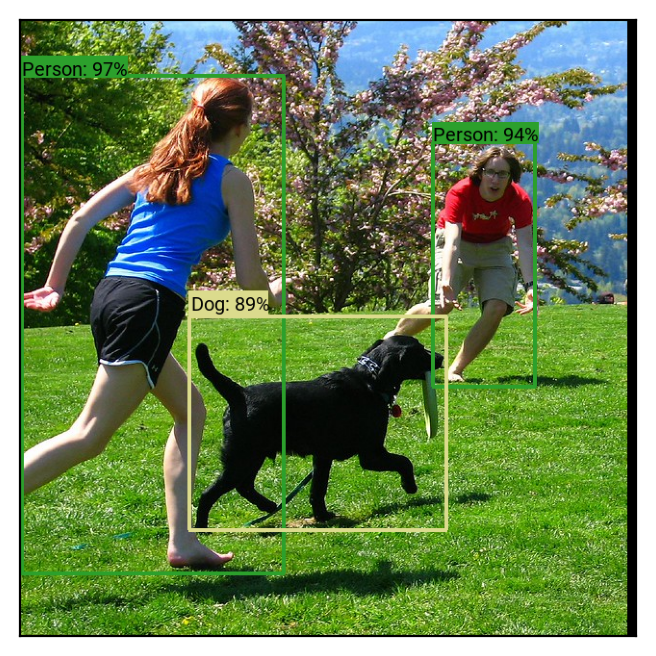

In [11]:
plot_image_with_boxes(model_inputs['dog'], model_outputs['dog'])
model_output_to_scores_df(model_outputs['dog'])

label     score
0   Dog  0.952927
8   Car  0.823767

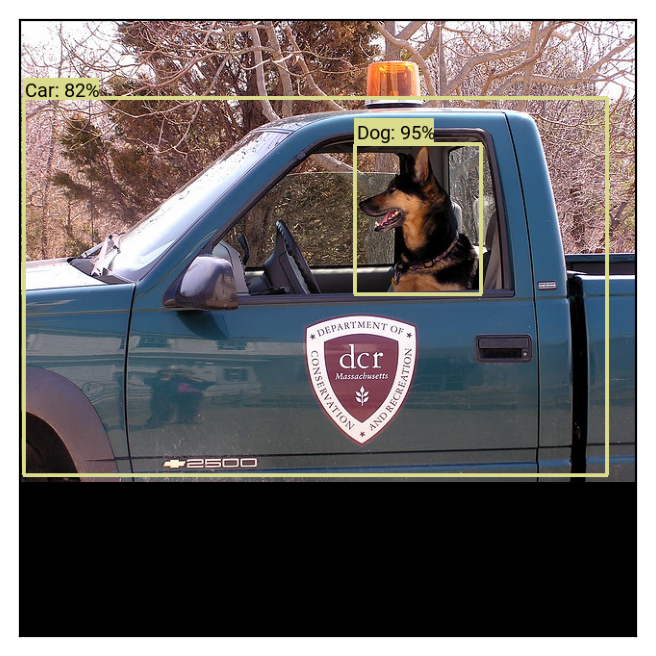

In [13]:
plot_image_with_boxes(model_inputs['truck + dog'], model_outputs['truck + dog'])
model_output_to_scores_df(model_outputs['truck + dog']).head(5)

Empty DataFrame
Columns: [label, score]
Index: []

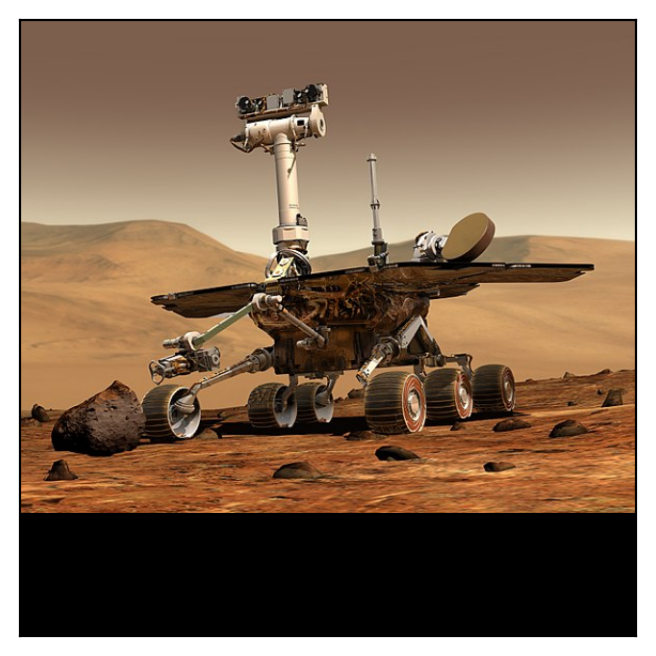

In [14]:
plot_image_with_boxes(model_inputs['rover'], model_outputs['rover'])
model_output_to_scores_df(model_outputs['rover']).head(5)